# Try 1

In [1]:
import torch
from torch_geometric.data import Data
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import csv

In [2]:
EDGES = "data/edges.csv"
NODES = "data/nodes.csv"
TRAFFIC = "data/traffic.csv"

In [19]:
edges = []
edge_attr = []
with open(EDGES, "r") as f:
    reader = csv.reader(f)
    for i,row in enumerate(reader): 
        if i == 0:
            continue
        edges.append([int(row[1])-1, int(row[2])-1])
        edges.append([int(row[2])-1, int(row[1])-1])
        edge_attr.append([float(row[3])])
        edge_attr.append([float(row[3])])

# edge_index = torch.tensor(edges, dtype=torch.long) 
# edge_attr = torch.tensor(edge_attr, dtype = torch.float)

data = []

with open(NODES, "r") as f:
    reader = csv.reader(f)
    for i,row in enumerate(reader): 
        if i == 0:
            continue
        data.append([float(row[1]), float(row[2])])

x = torch.tensor(data, dtype=torch.float)

In [4]:
data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr= edge_attr)

In [5]:
data

Data(x=[9, 2], edge_index=[2, 28], edge_attr=[28, 1])

In [6]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (9, 9)
[[0 1 1 0 1 0 0 1 0]
 [1 0 0 0 0 0 0 0 1]
 [1 0 0 1 1 0 0 0 0]
 [0 0 1 0 2 1 0 0 0]
 [1 0 1 2 0 0 0 1 0]
 [0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 1 0]
 [1 0 0 0 1 0 1 0 1]
 [0 1 0 0 0 0 0 1 0]]


/home/vignesh/Projects/GCN/.venv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


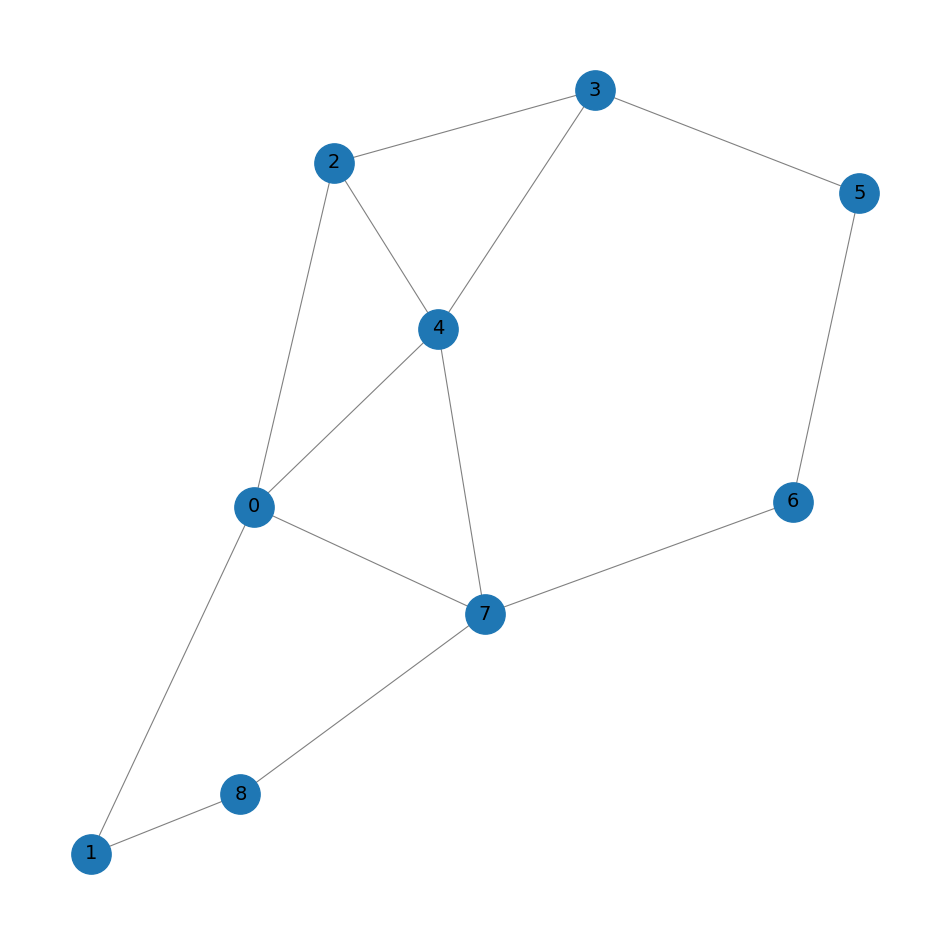

In [7]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

In [8]:
data.validate()

True

# Try 2

In [13]:
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()

In [16]:
dataset = loader.get_dataset(lags=14)

In [21]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [22]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [26]:
from tqdm import tqdm

model = RecurrentGCN(node_features=14, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(5)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 5/5 [00:33<00:00,  6.79s/it]


In [27]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.8076


# Try 3

## Data Loading

In [264]:
EDGES = "data/edges.csv"
NODES = "data/nodes.csv"
TRAFFIC = "traffic.csv"

edge_indexes = []
edge_weights = []
with open(EDGES, "r") as f:
    reader = csv.reader(f)
    for i,row in enumerate(reader): 
        if i == 0:
            continue
        edge_indexes.append([int(row[1])-1, int(row[2])-1])
        edge_indexes.append([int(row[2])-1, int(row[1])-1])
        edge_weights.append([float(row[3])])
        edge_weights.append([float(row[3])])

# edge_indexes = np.array(edge_indexes, np.int32) 
# edge_weights = np.array(edge_weights, np.float64)

edge_indexes = torch.tensor(edge_indexes, dtype= torch.int64) 
edge_weights = torch.tensor(edge_weights, dtype= torch.float)

In [265]:
from collections import defaultdict

traffic_data = defaultdict(list)

with open(TRAFFIC) as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i==0: 
            continue
        traffic_data[row[0]].append({
            "node":int(row[6])-1, 
            "record": [int(row[1]), int(row[2]), int(row[3]), int(row[4]), int(row[5]), int(row[7])] 
        })

traffic_sequence = []

for reading in traffic_data:
    record = []
    for i in range(len(traffic_data[reading])):
        record.append(traffic_data[reading][i]["record"])
    traffic_sequence.append(record)

features = []
targets = []

for i in range(len(traffic_sequence)-1):
    features.append(traffic_sequence[i])
    y = []
    for i in traffic_sequence[i+1]:
        y.append(i[-1])
    targets.append(y)

features = np.array(features, np.int32) 
targets = np.array(targets, np.int32)

In [266]:
train_sequences = []
targets = []
time_steps = 5
delay = 6
for i in range(0,len(traffic_sequence),time_steps):
    if i+time_steps+delay>=len(traffic_sequence):
        break

    subseq = traffic_sequence[i:i+time_steps]
    if len(subseq) == time_steps:
        train_sequences.append(subseq)
    
    targets.append([i[-1] for i in traffic_sequence[i+delay]])

In [267]:
train_sequences = torch.tensor(train_sequences, dtype = torch.float)
targets = torch.tensor(targets, dtype = torch.float)

In [272]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_sequences, targets, test_size=0.2, random_state=42)

## Train Sequences

In [71]:
from torch_geometric_temporal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

In [114]:
temporal = StaticGraphTemporalSignal(
    edge_index= edge_indexes,
    edge_weight= edge_weights,
    features= features,
    targets= targets
    )

train, test = temporal_signal_split(temporal, train_ratio= 0.7)

In [113]:
train[0]

Data(x=[9, 6], edge_index=[28, 2], edge_attr=[28, 1], y=[9])

## Model

In [241]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.attention import STConv

class STGCN(torch.nn.Module):
    def __init__(self, num_nodes, in_channels):
        super(STGCN, self).__init__()
        self.stconv1 = STConv(num_nodes,in_channels, 6 , 6, 3, 3)
        self.linear1 = torch.nn.Linear(6, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.stconv1(x, edge_index, edge_weight)
        split_tensors = [h.reshape(9,6)[i, :] for i in range(h.reshape(9,6).size(0))]
        # h = (h.reshape((1,-1)).squeeze())
        result = []
        for i in split_tensors:
            k = F.relu(i)
            result.append(self.linear1(k))
        return torch.tensor(result, dtype = torch.float)

In [318]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.attention import STConv

class STGCN(torch.nn.Module):
    def __init__(self, num_nodes, in_channels, hidden, features):
        super(STGCN, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.features = features
        self.hidden = hidden
        self.stconv1 = STConv(self.num_nodes, self.in_channels, self.hidden, features, 3, 3)
        self.linear1 = torch.nn.Linear(features, 10)
        self.linear2 = torch.nn.Linear(10, 1)
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_weight):
        h = self.stconv1(x, edge_index, edge_weight)
        h = h.reshape(self.num_nodes, self.features)  # Assuming the shape after reshaping is correct
        
        # Apply ReLU and Linear layer to each node representation
        result = []
        for i in range(h.size(0)):
            k = F.elu(h[i, :])
            k = self.linear1(k)
            k = self.dropout(k)
            k = F.elu(k)
            result.append(self.linear2(k))
        
        # Stack the results into a tensor
        result = torch.stack(result)
        return result

In [329]:
X_train[0].dtype

torch.float32

In [319]:
from tqdm import tqdm

model = STGCN(num_nodes = 9, in_channels = 6, hidden=10, features= 6)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = []
validation_history = []

for epoch in range(15):

    model.train()
    for time, (snapshot, target) in tqdm(enumerate(zip(X_train, y_train))):
        snapshot = snapshot.reshape(1,*snapshot.shape)
        y_hat = model(snapshot, edge_indexes.T, edge_weights)
        cost = torch.mean((y_hat-target)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss = cost.detach().numpy()
    history.append(loss)
    print(f"Loss: {loss}")

    model.eval()
    with torch.no_grad():
        val_losses = []
        for time, (snapshot, target) in tqdm(enumerate(zip(X_test, y_test))):
            # snapshot = torch.tensor(snapshot, dtype=torch.float32).reshape(1, num_nodes, in_channels)
            snapshot = snapshot.reshape(1,*snapshot.shape)            
            y_hat = model(snapshot, edge_indexes.T, edge_weights)
            val_cost = torch.mean((y_hat - target) ** 2)
            val_losses.append(val_cost.detach().numpy())
        
        val_loss = np.mean(val_losses)
        validation_history.append(val_loss)
    
    print(f"Epoch {epoch+1}/{15}, Training Loss: {loss}, Validation Loss: {val_loss}")


275it [00:01, 143.93it/s]


Loss: 250.9137420654297


69it [00:00, 451.17it/s]


Epoch 1/15, Training Loss: 250.9137420654297, Validation Loss: 540.806396484375


275it [00:01, 146.28it/s]


Loss: 137.62237548828125


69it [00:00, 468.14it/s]


Epoch 2/15, Training Loss: 137.62237548828125, Validation Loss: 302.85394287109375


275it [00:01, 159.14it/s]


Loss: 101.47926330566406


69it [00:00, 475.73it/s]


Epoch 3/15, Training Loss: 101.47926330566406, Validation Loss: 151.0440673828125


275it [00:01, 152.12it/s]


Loss: 110.39796447753906


69it [00:00, 454.82it/s]


Epoch 4/15, Training Loss: 110.39796447753906, Validation Loss: 140.14169311523438


275it [00:01, 153.14it/s]


Loss: 106.68043518066406


69it [00:00, 442.32it/s]


Epoch 5/15, Training Loss: 106.68043518066406, Validation Loss: 175.1276092529297


275it [00:01, 152.18it/s]


Loss: 144.21998596191406


69it [00:00, 406.52it/s]


Epoch 6/15, Training Loss: 144.21998596191406, Validation Loss: 159.10459899902344


275it [00:01, 149.93it/s]


Loss: 94.94798278808594


69it [00:00, 402.11it/s]


Epoch 7/15, Training Loss: 94.94798278808594, Validation Loss: 143.69615173339844


275it [00:01, 152.13it/s]


Loss: 77.27052307128906


69it [00:00, 407.75it/s]


Epoch 8/15, Training Loss: 77.27052307128906, Validation Loss: 130.92837524414062


275it [00:01, 168.64it/s]


Loss: 79.35102081298828


69it [00:00, 464.44it/s]


Epoch 9/15, Training Loss: 79.35102081298828, Validation Loss: 124.01582336425781


275it [00:01, 151.68it/s]


Loss: 59.380348205566406


69it [00:00, 402.43it/s]


Epoch 10/15, Training Loss: 59.380348205566406, Validation Loss: 109.16142272949219


275it [00:01, 148.65it/s]


Loss: 114.07970428466797


69it [00:00, 451.71it/s]


Epoch 11/15, Training Loss: 114.07970428466797, Validation Loss: 100.72525024414062


275it [00:01, 140.85it/s]


Loss: 86.95238494873047


69it [00:00, 469.21it/s]


Epoch 12/15, Training Loss: 86.95238494873047, Validation Loss: 93.41616821289062


275it [00:01, 152.90it/s]


Loss: 64.88180541992188


69it [00:00, 435.50it/s]


Epoch 13/15, Training Loss: 64.88180541992188, Validation Loss: 95.63276672363281


275it [00:01, 148.58it/s]


Loss: 112.31857299804688


69it [00:00, 424.64it/s]


Epoch 14/15, Training Loss: 112.31857299804688, Validation Loss: 97.15580749511719


275it [00:01, 163.52it/s]


Loss: 74.398193359375


69it [00:00, 487.88it/s]

Epoch 15/15, Training Loss: 74.398193359375, Validation Loss: 87.21793365478516


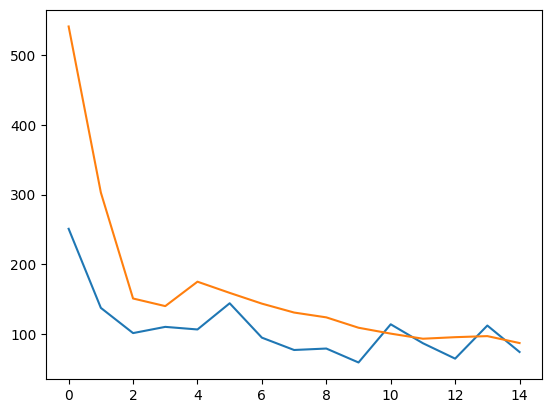

In [321]:
plt.plot(history)
plt.plot(validation_history)
plt.show()

In [322]:
torch.save(model.state_dict(), 'models/stgcn_model_final.pth')

In [307]:
model.load_state_dict(torch.load('models/stgcn_model_22.pth'))

model.eval()
with torch.no_grad():
    val_losses = []
    for time, (snapshot, target) in tqdm(enumerate(zip(X_test, y_test))):
        # snapshot = torch.tensor(snapshot, dtype=torch.float32).reshape(1, num_nodes, in_channels)
        snapshot = snapshot.reshape(1,*snapshot.shape)            
        y_hat = model(snapshot, edge_indexes.T, edge_weights)
        val_cost = torch.mean((y_hat - target) ** 2)
        val_losses.append(val_cost.detach().numpy())
    
    val_loss = np.mean(val_losses)
    validation_history.append(val_loss)

print(f"Epoch {epoch+1}/{20}, Training Loss: {loss}, Validation Loss: {val_loss}")

RuntimeError: Error(s) in loading state_dict for STGCN:
	Missing key(s) in state_dict: "linear2.weight", "linear2.bias". 
	size mismatch for linear1.weight: copying a param with shape torch.Size([1, 5]) from checkpoint, the shape in current model is torch.Size([10, 5]).
	size mismatch for linear1.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([10]).

In [115]:
while True:
    count = 0
    try:
        next(train)
        count += 1
    except StopIteration:
        print(count)
        break

AttributeError: 'StaticGraphTemporalSignal' object has no attribute 't'

In [1]:
from ultralytics import YOLO

model = YOLO('weights/traffic_model.pt')

model.predict('trail.jpg')

/home/vignesh/Projects/GCN/.venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


image 1/1 /home/vignesh/Projects/GCN/trail.jpg: 320x640 11 autos, 16 bikes, 40 persons, 1 truck, 121.2ms
Speed: 1.6ms preprocess, 121.2ms inference, 392.6ms postprocess per image at shape (1, 3, 320, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'auto', 1: 'bike', 2: 'car', 3: 'person', 4: 'truck'}
 obb: None
 orig_img: array([[[  8,  13,  12],
         [  8,  13,  12],
         [  8,  13,  12],
         ...,
         [ 20,  28,  28],
         [ 21,  29,  29],
         [ 21,  29,  29]],
 
        [[  9,  11,  11],
         [  9,  11,  11],
         [  9,  11,  11],
         ...,
         [ 18,  26,  26],
         [ 18,  26,  26],
         [ 19,  27,  27]],
 
        [[ 10,  10,  10],
         [ 10,  10,  10],
         [ 10,  10,  10],
         ...,
         [ 17,  25,  25],
         [ 17,  25,  25],
         [ 18,  26,  26]],
 
        ...,
 
        [[243, 247, 236],
         [243, 247, 236],
         [241, 245, 234],
         ...,
         [171, 156, 147],
         [118, 102,  95],
         [ 44,  29,  20]],
 
        [[231, 234, 225],
         [233, 236, 227],
         [233,